In [1]:
import pyfesom2 as pf
import xarray as xr
import os
import pandas as pd
from collections import OrderedDict
from itertools import product
import matplotlib.pylab as plt
%matplotlib inline

osgeo is not installed, conversion to Geo formats like Geotiff (fesom2GeoFormat) will not work.


In [9]:
# parameters cell
meshpath = '/p/project/chhb19/streffing1/input/fesom2/core2/'
abg = [0, 0, 0]
variable = 'temp'
input_paths = ["/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/fesom/",
               ]
input_names = ['HIST']
years = range(1990, 2014)
reference_path = '/p/project/chhb19/streffing1/postprocessing/climatologies/fdiag/output_awicm3/'
reference_name = 'clim'
reference_years = 1958
rowscol=[1,1]
bbox = [-180, 180, -80, 90]
res = [360, 180]
mapproj='pc'
figsize=(24, 14)
depth = 0
levels = [-5, 5, 21]
units = r'$^\circ$C'
dpi=300
how="mean"
ofile = None

In [10]:
if input_names is None:
    input_names = []
    for run in input_paths:
        run = os.path.join(run, '')
        input_names.append(run.split('/')[-2])

In [11]:
mesh = pf.load_mesh(meshpath, abg=abg, 
                    usepickle=True, usejoblib=False)

/p/project/chhb19/streffing1/input/fesom2/core2/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /p/project/chhb19/streffing1/input/fesom2/core2/pickle_mesh_py3_fesom2


In [12]:
plotds = OrderedDict()
data_reference = pf.get_data(reference_path, variable, reference_years, mesh, depth = depth, how=how, compute=True, silent=True)
plotds[depth] = {}
for exp_path, exp_name  in zip(input_paths, input_names):
    data_test      = pf.get_data(exp_path, variable, years, mesh, depth = depth, how=how, compute=True, silent=True)
    data_difference= data_test - data_reference
    title = exp_name+" - "+reference_name
    plotds[depth][title] = {}
    plotds[depth][title]['data'] = data_difference
    if (data_difference.max() == data_difference.min() == 0):
        plotds[depth][title]['nodiff'] = True
    else:
        plotds[depth][title]['nodiff'] = False

('nod2',)
False
False
True
('nod2',)
False
False
True


In [13]:
def data_to_plot(plotds, depth):
    plot_data = []
    plot_names = []
    for key, value in plotds[depth].items():
        if value['nodiff'] is False:
            plot_data.append(value['data'])
            plot_names.append(key)
                
    return plot_data, plot_names

In [14]:
plot_data, plot_names = data_to_plot(plotds, depth)
if not plot_data:
    print('There is no difference between fields')
    identical = True
else:
    identical = False

if len(plot_data) == 1:
    plot_data = plot_data[0]
    plot_names = plot_names[0]


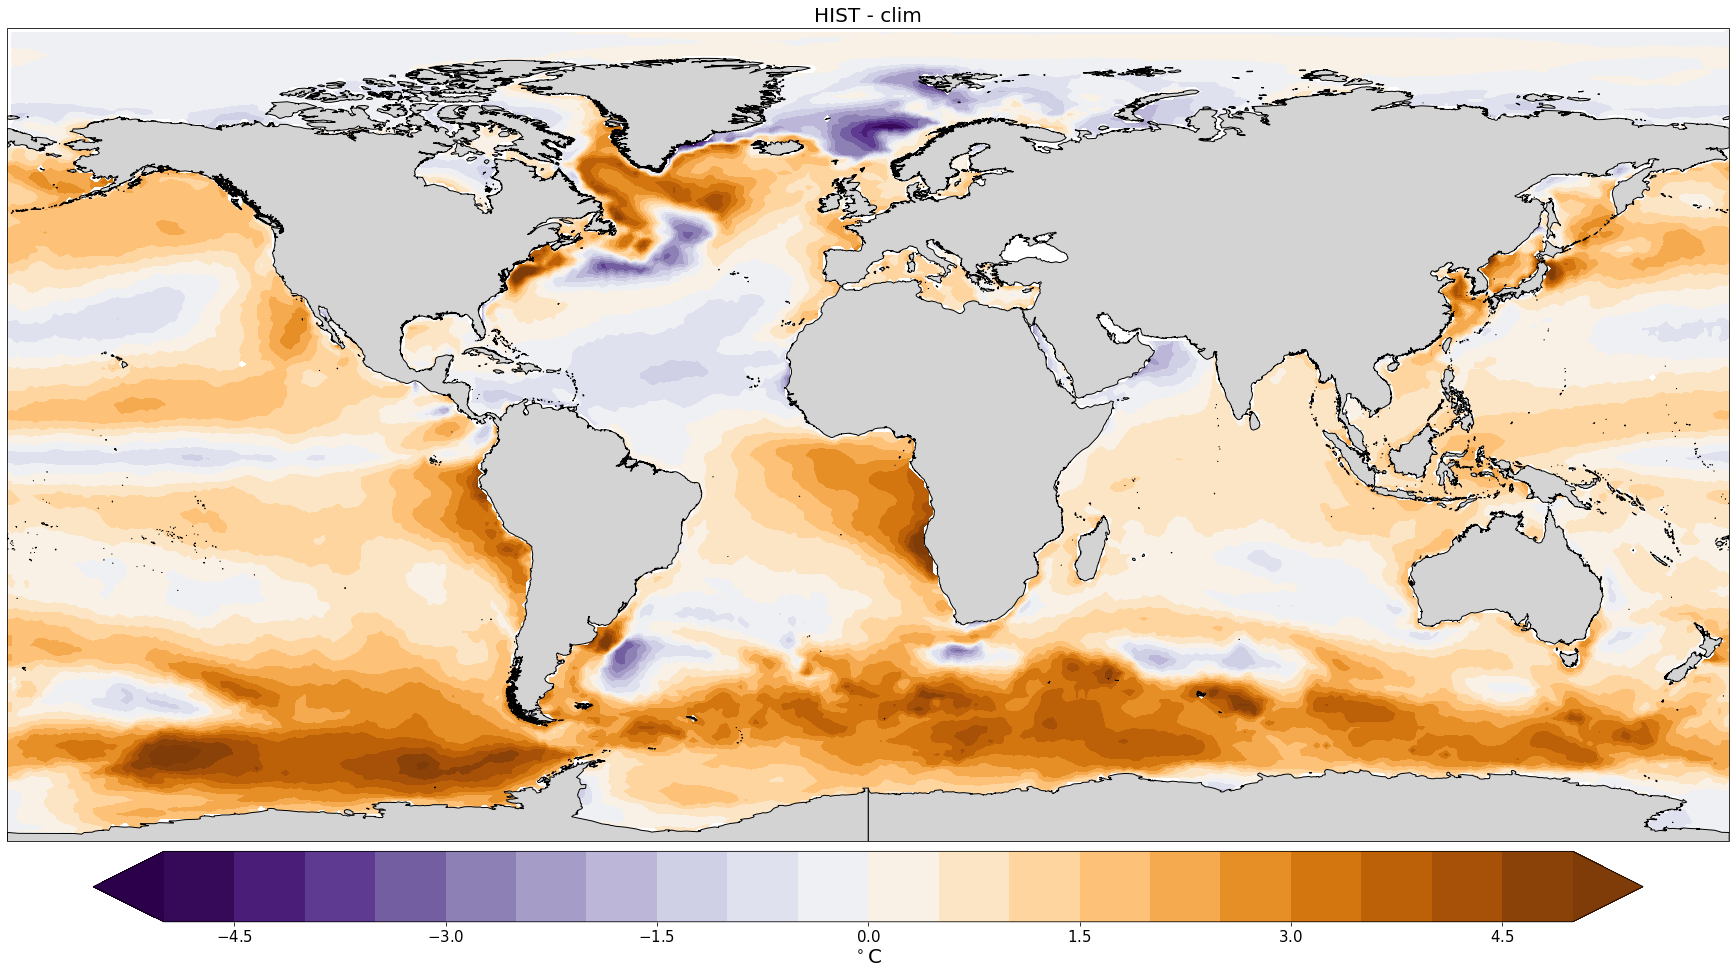

In [15]:
if not identical:
    pf.plot(mesh, 
        plot_data,
        rowscol=rowscol,
        titles=plot_names,
        mapproj=mapproj,
        cmap='PuOr_r', 
        levels=levels,
        figsize = figsize, 
        box=bbox, 
        res = res,
        units = units);
if ofile is not None:
    plt.savefig(ofile, dpi=dpi)
    os.system(f'convert {ofile} -trim {ofile}_trimmed.png')
    os.system(f'mv {ofile}_trimmed.png {ofile}')